=== Feature Summary ===
             permno                           date           ofi  \
count  41810.000000                          41810  41810.000000   
mean   53787.938771  2023-12-11 11:44:28.012436736     -0.016280   
min    10104.000000            2022-12-20 00:00:00     -0.887279   
25%    21936.000000            2023-06-28 00:00:00     -0.113715   
50%    59248.000000            2023-12-28 00:00:00     -0.017957   
75%    83443.000000            2024-06-26 00:00:00      0.080437   
max    93436.000000            2024-12-19 00:00:00      0.845264   
std    29889.670444                            NaN      0.151171   

            ofi_abs       ofi_std    buy_volume   sell_volume        volume  \
count  41810.000000  41810.000000  4.181000e+04  4.181000e+04  4.181000e+04   
mean       0.118531      0.204949  6.042628e+05  6.171271e+05  1.222519e+06   
min        0.000006      0.040055  5.970000e+02  7.340000e+02  1.860000e+03   
25%        0.046899      0.157440  1.247075e+05

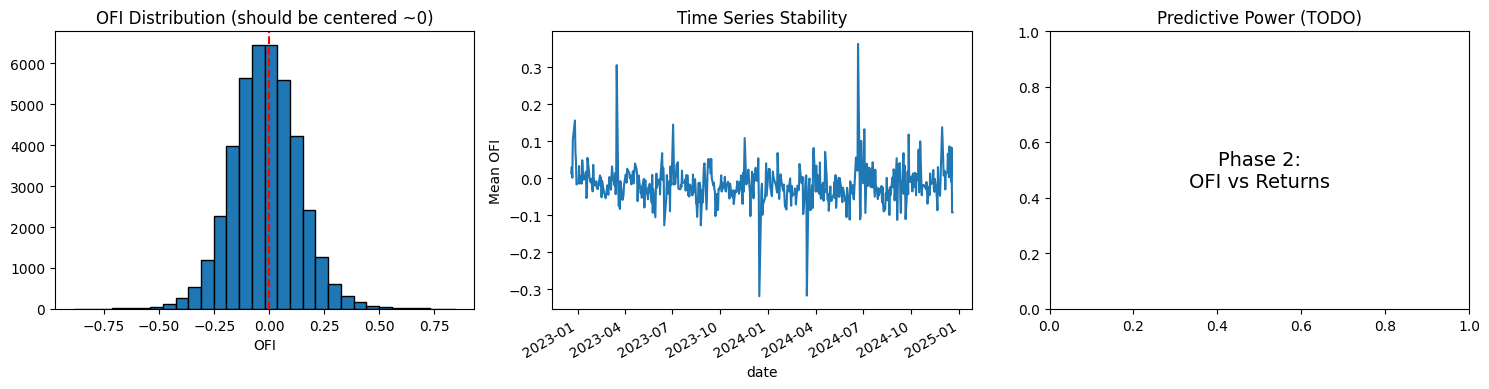

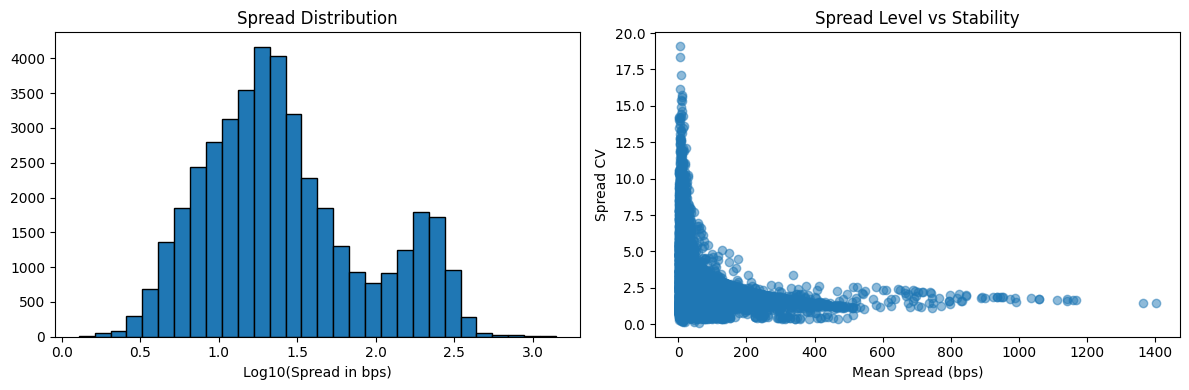

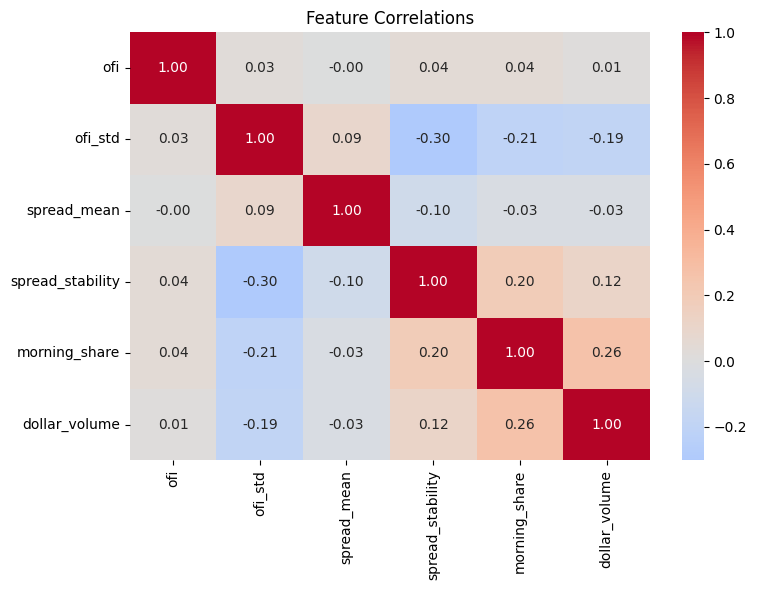


=== Data Quality ===
Missing values:
event_id                     0
permno                       0
date                         0
ofi                          0
ofi_abs                      0
ofi_std                      0
buy_volume                   0
sell_volume                  0
volume                       0
num_trades                   0
avg_trade_size               0
classification_method        0
dollar_volume                0
share_volume                 0
abnormal_vol_ratio       41810
morning_share                0
spread_mean                  0
spread_std                   0
spread_stability             0
quoted_spread_mean           0
spread_p95                   0
num_quotes                   0
num_quotes_1s                0
dtype: int64

Classification method:
classification_method
lee_ready    41810
Name: count, dtype: int64

Events: 4181
Permnos: 531
Days per event: count    4181.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load features
df = pd.read_parquet("../data/processed/daily_features_full.parquet")

# ============================================================
# 1. Basic Stats
# ============================================================
print("=== Feature Summary ===")
print(df.describe())

# ============================================================
# 2. OFI Distribution
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# OFI histogram
axes[0].hist(df['ofi'], bins=30, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('OFI')
axes[0].set_title('OFI Distribution (should be centered ~0)')

# OFI by date
df.groupby('date')['ofi'].mean().plot(ax=axes[1])
axes[1].set_ylabel('Mean OFI')
axes[1].set_title('Time Series Stability')

# OFI vs forward returns (placeholder for Phase 2)
axes[2].text(0.5, 0.5, 'Phase 2:\nOFI vs Returns', 
             ha='center', va='center', fontsize=14)
axes[2].set_title('Predictive Power (TODO)')

plt.tight_layout()
plt.show()

# ============================================================
# 3. Spread Analysis
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Spread distribution (log scale)
axes[0].hist(np.log10(df['spread_mean']*10000), bins=30, edgecolor='black')
axes[0].set_xlabel('Log10(Spread in bps)')
axes[0].set_title('Spread Distribution')

# Spread stability
axes[1].scatter(df['spread_mean']*10000, df['spread_stability'], alpha=0.5)
axes[1].set_xlabel('Mean Spread (bps)')
axes[1].set_ylabel('Spread CV')
axes[1].set_title('Spread Level vs Stability')

plt.tight_layout()
plt.show()

# ============================================================
# 4. Cross-Sectional Correlations
# ============================================================
corr_features = ['ofi', 'ofi_std', 'spread_mean', 'spread_stability', 
                 'morning_share', 'dollar_volume']

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

# ============================================================
# 5. Data Quality Checks
# ============================================================
print("\n=== Data Quality ===")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nClassification method:\n{df['classification_method'].value_counts()}")
print(f"\nEvents: {df['event_id'].nunique()}")
print(f"Permnos: {df['permno'].nunique()}")
print(f"Days per event: {df.groupby('event_id').size().describe()}")

# ============================================================
# 6. Sanity Checks
# ============================================================
print("\n=== Sanity Checks ===")

# Buy + Sell should equal Volume
volume_check = np.allclose(
    df['buy_volume'] + df['sell_volume'], 
    df['volume']
)
print(f"Buy + Sell = Volume: {volume_check}")

# OFI should match (buy - sell) / volume
ofi_check = np.allclose(
    (df['buy_volume'] - df['sell_volume']) / df['volume'],
    df['ofi']
)
print(f"OFI formula correct: {ofi_check}")

# Share volume should equal volume
share_volume_check = (df['share_volume'] == df['volume']).all()
print(f"Share volume matches: {share_volume_check}")

print("\n✓ Feature validation complete")

<Axes: title={'center': 'Cumulative OFI: E1381'}>

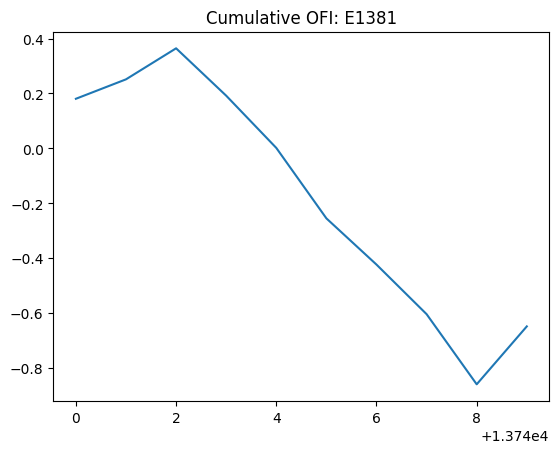

In [13]:
sample_event = df["event_id"].sample(200).iloc[0]
tmp = df[df["event_id"] == sample_event].sort_values("date")

tmp["ofi"].cumsum().plot(title=f"Cumulative OFI: {sample_event}")


<Axes: title={'center': 'OFI Persistence vs Spread Instability'}, xlabel='ofi_std', ylabel='spread_cv'>

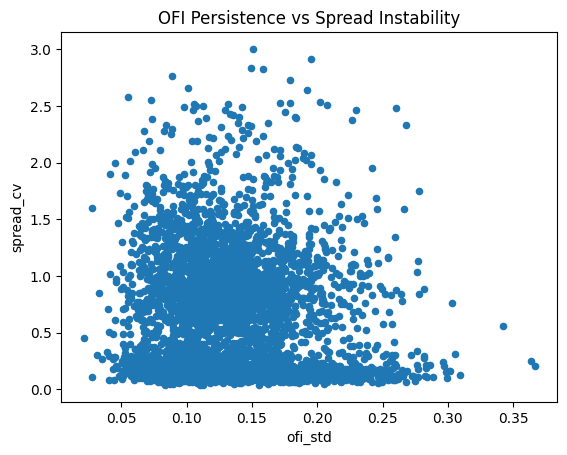

In [7]:
event_level = (
    df.groupby("event_id")
      .agg(
          ofi_std=("ofi", "std"),
          spread_cv=("spread_mean", lambda x: x.std() / x.mean())
      )
)

event_level.plot.scatter(
    x="ofi_std",
    y="spread_cv",
    title="OFI Persistence vs Spread Instability"
)


In [4]:
df["ofi_abs"] = df["ofi"].abs()

df["ofi_abs"].quantile([0.95, 0.99])


0.95    0.298510
0.99    0.429955
Name: ofi_abs, dtype: float64

In [5]:
df.nlargest(5, "ofi_abs")[["event_id","date","ofi","volume"]]


,event_id,date,ofi,volume
31690,E3182,2024-07-03,-0.887279,2316668
41546,E4171,2024-11-29,0.845264,2941236
31601,E3173,2024-07-03,0.819385,344777
31750,E3188,2024-07-03,0.817898,199833
41594,E4176,2024-11-29,-0.811597,4187002


<Axes: xlabel='event_id'>

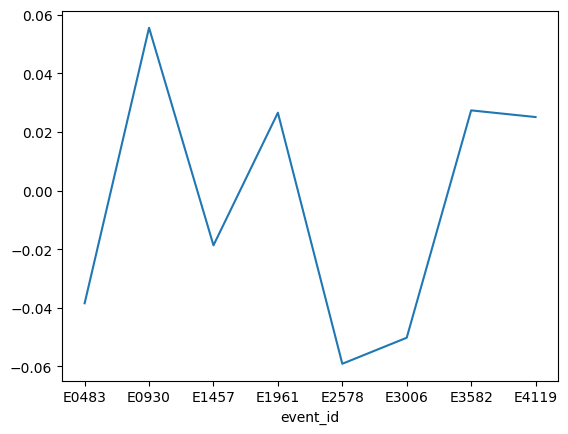

In [14]:
permno = df["permno"].sample(1).iloc[0]

df[df["permno"] == permno].groupby("event_id")["ofi"].mean().plot()
